In [69]:
import os
import pandas as pd
import numpy as np
import seaborn as sb
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import yfinance as yf
import matplotlib.pyplot as plt
from fastai.tabular.all import add_datepart

In [70]:
# from data import get_hist

In [71]:
ticker = 'CL=F' # stock ticker symbol: WTI Crude Oil
period = 'max' # time range to look at: all time
interval = '1d' # time interval for data collected: daily
search = 'Open' # Low, High, Open, Close, Volume

In [72]:
def get_hist(tck, time, ivl, srch):
    tick = yf.Ticker(tck)
    df = tick.history(period=time, interval=ivl)

    df = df[[srch]]

    # reformat data
    df = df.loc[::-1]
    df = df.reset_index()

    # add date data
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    # gets rid of datetime values
    df = df.drop('Date', axis=1)

    # start of year is never a trading day so removed
    df = df.drop(columns='Is_year_start')

    return df

In [73]:
# get historic data
df = get_hist(ticker, period, interval, search)

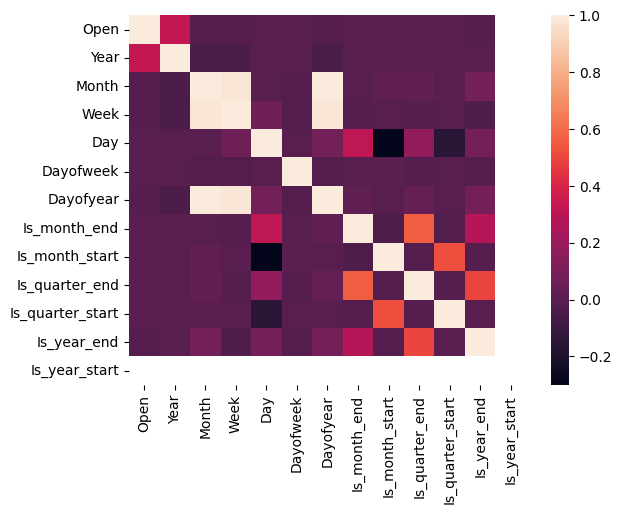

In [68]:
dataplot = sb.heatmap(df.corr())
plt.show()

In [48]:
# create test set of last year of data
test = df.drop(df.tail(df.shape[0]-365).index, inplace = False)
train = df

In [49]:
y_train = train[search]
X_train = train.drop(columns=search)
y_test = test[search]
X_test = test.drop(columns=search)

In [50]:
# dates = {
#     'year':[],
#     'month':[],
#     'day':[]
# }
# for i in range(5):
#     dates['year'] += [2023]
#     dates['month'] += [1]
#     dates['day'] += [25+i]
# future = pd.DataFrame.from_dict(dates)
# future

In [51]:
# Instantiation
model = xg.XGBRegressor(eta=.15, objective='reg:squarederror', n_estimators=100, seed=123)

In [52]:
# Fitting the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.15, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [53]:
# Predict the model
yhat = model.predict(X_test)

In [54]:
print(len(yhat))
print(yhat[0])
print(y_test[0])

365
78.78781
76.79000091552734


In [55]:
# RMSE Computation
rmse = np.sqrt(MSE(y_test, yhat))

In [56]:
print("RMSE : % f" %(rmse))

RMSE :  1.660899


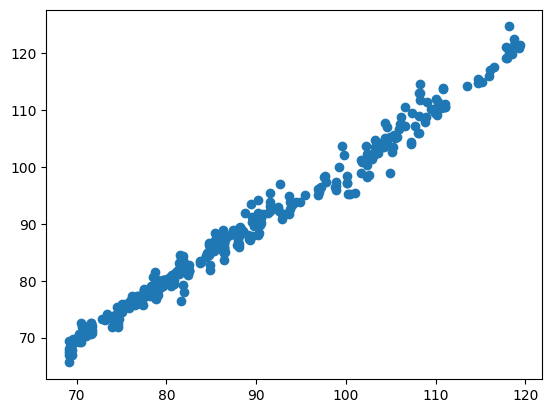

In [57]:
plt.scatter(yhat, y_test)
plt.show()

In [58]:
# todo:
# graph loss
# setup a prediction view method
# predict future
# make test set the last year instead of 5000
# run daily
# adjusted closing prices of the last N=10 days